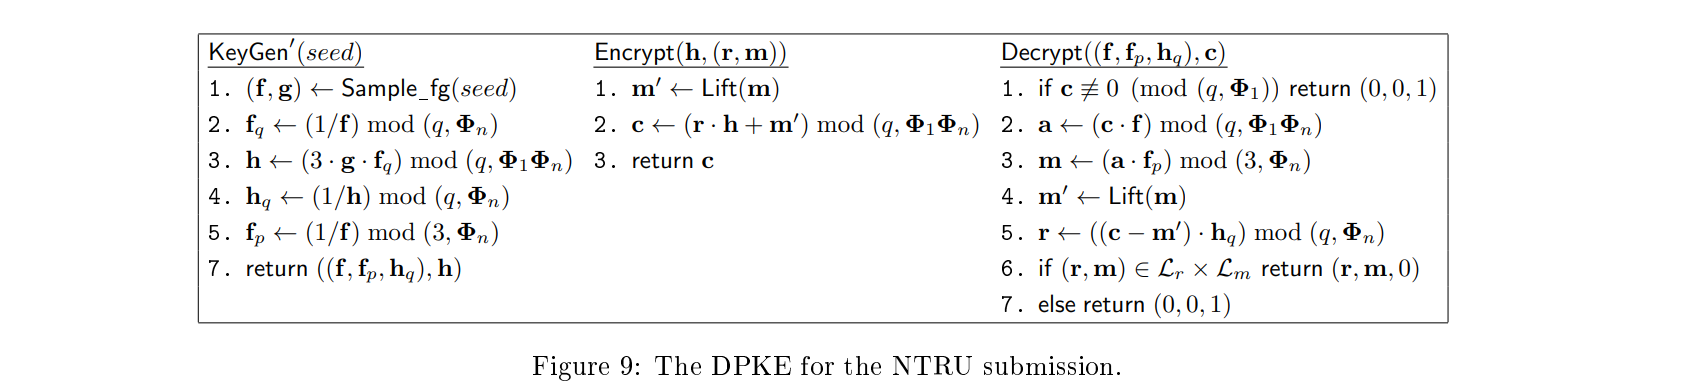

In [ ]:

import random
import unittest

def sample_fg(S, n, q):
    d = q//8-2
    f_coeffs = random.choices([-1, 0, 1], k=n-1)
    while not any(f_coeffs):                            # para n pequeno,
        f_coeffs = random.choices([-1, 0, 1], k=n-1)
    
    ind = list(range(n-1))
    random.shuffle(ind)
    pos = ind[0:d//2]
    neg = ind[d//2:d]

    g_coeffs = [0]*(n-1)
    for i in pos:
        g_coeffs[i] = 1
    for i in neg:
        g_coeffs[i] = -1
    return f_coeffs, g_coeffs 

def Sq_inverse(S2, Sq, a):
    v0 = S2(a.lift())^(-1)
    v0 = Sq(v0.lift())
    for i in range(4):
        v0 = Sq(v0 * (2 - a * v0))
    return v0

def keygen(S, S2, S3, Sq, Rq, n, q):
    p = 3
    for attempt in range(5):
        f_coeffs, g_coeffs = sample_fg(S, n, q)

        fq = Sq_inverse(S2, Sq, Sq(f_coeffs))
        fq_lift = fq.lift() # polinômio em Z_q[x]
        h = Rq(p) * Rq(g_coeffs) * Rq(fq_lift)
        h_Sq = Sq(h.lift())
        hq = Sq_inverse(S2, Sq, h_Sq)
        fp = 1 / S3(f_coeffs)

        print(f"[n,q]=[{n},{q}], attempt: {attempt + 1}")
        return f_coeffs, g_coeffs, fp, fq, h, hq

    raise ValueError("limite de tentativas")


class TestKeygen(unittest.TestCase):
    def setUp(self):
        self.qs = {}
        self.rings = {}
        # self.qs[5] = 32 
        # self.qs[7] = 32   
        # self.ns = [5, 7]
        self.qs[509] = 2048
        self.ns = [509]
        self.p = 3

        for n in self.ns:
            q = self.qs[n]
            Z.<xZ> = ZZ[]                                   # ZZ[x]
            Z2.<xZ2> = Integers(2)[]                        # (ZZ/2ZZ)[x]
            Z3.<xZ3> = Integers(3)[]                        # (ZZ/3ZZ)[x]
            Zq.<xZq> = Integers(q)[]                        # (ZZ/2048ZZ)[x]
            Phi_n = lambda x : (x^n-1)//(x-1)
            Phi_1 = lambda x : (x - 1)
            R.<xR> = Z.quotient(Phi_1(xZ) * Phi_n(xZ))      # ZZ[x] / (x^n-1)
            S.<xS> = Z.quotient(Phi_n(xZ))                  # ZZ[x] / (x^(n-1) + x^(n-2) + ... + x + 1)
            R3.<xR3> = Z3.quotient(Phi_1(xZ3) * Phi_n(xZ3)) # ZZ[x] / (3, x^n-1)
            Rq.<xRq> = Zq.quotient(Phi_1(xZq) * Phi_n(xZq)) # ZZ[x] / (q, x^n-1)
            S2.<xS2> = Z2.quotient(Phi_n(xZ2))              # ZZ[x] / (2, x^(n-1) + x^(n-2) + ... + x + 1)
            S3.<xS3> = Z3.quotient(Phi_n(xZ3))              # ZZ[x] / (3, x^(n-1) + x^(n-2) + ... + x + 1)
            Sq.<xSq> = Zq.quotient(Phi_n(xZq))              # ZZ[x] / (q, x^(n-1) + x^(n-2) + ... + x + 1)            

            self.rings[(n, q)] = {
                'S'    :  S,
                'Sq'   :  Sq,
                'Rq'   :  Rq,
                'S2'   :  S2,
                'S3'   :  S3,
                'R'    :  R,
                'Phi_n':  Phi_n
            }

    def test_parameters(self):
        for n in self.ns:
            q = self.qs[n]
            d = q//8 - 2
            self.assertTrue((q & (q - 1)) == 0)
            self.assertGreaterEqual(q, 32)
            self.assertLessEqual(d, 2*n/3)

    def test_sample_fg(self):
        for n in self.ns:
            q = self.qs[n]
            rings = self.rings[(n, q)]

            for i in range(10):
                f_coeffs, g_coeffs = sample_fg(rings['S'], n, q) 
                f = rings['S'](f_coeffs) 
                g = rings['S'](g_coeffs)

                f_lift = f.lift()              # reconstruir polinômios
                g_lift = g.lift()              # apenas uma vez 
                deg_f  = f_lift.degree()
                deg_g  = g_lift.degree()
                self.assertLessEqual(deg_f, n-2)
                self.assertLessEqual(deg_g, n-2)
                self.assertTrue(all(c in [-1, 0, 1] for c in f_lift.list()))
                self.assertTrue(all(c in [-1, 0, 1] for c in g_lift.list()))
                self.assertNotEqual(f, 0)
                self.assertNotEqual(g, 0)
                self.assertEqual(sum(1 for c in g_lift.list() if c == 1), q//16 - 1)
                self.assertEqual(sum(1 for c in g_lift.list() if c == -1), q//16 - 1)

    def test_inverse(self):
        for n in self.ns:
            q = self.qs[n]
            rings = self.rings[(n, q)]

            for _ in range(2):   # <-- este for precisa estar DENTRO do for de n
                f_coeffs, g_coeffs, fp, fq, h, hq = keygen(
                    rings['S'], rings['S2'], rings['S3'], rings['Sq'], rings['Rq'], n, q
                )
                # f * fq = 1 em S_q
                f_in_Sq = rings['Sq'](f_coeffs)
                self.assertEqual(f_in_Sq * fq, 1)

                # f * fp = 1 em S_3
                f_in_S3 = rings['S3'](f_coeffs)
                self.assertEqual(f_in_S3 * fp, 1)

                # h * hq = 1 em S_q
                h_Sq = rings['Sq'](h.lift())
                self.assertEqual(h_Sq * hq, 1)


unittest.main(argv=[''], exit=False)

t = TestKeygen()
t.setUp()  # inicializa os rings e variáveis compartilhadas
# Profiling do método test_parameters
print("Profiling test_parameters:")
%prun -l 10 t.test_parameters()  # -l 10 limita a exibição às 10 funções mais gastas
# Profiling do método test_sample_fg
print("\nProfiling test_sample_fg:")
t.setUp()  # garante que qualquer estado residual seja reinicializado
%prun -l 20 t.test_sample_fg()  # -l 20 para ver mais detalhes de funções internas
# Profiling do método test_inverse
print("\nProfiling test_inverse:")
t.setUp()
%prun -l 30 t.test_inverse()  # -l 30 para ver mais detalhes dentro do keygen